In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import csv
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
project_path = '/content/drive/My Drive/Colab Notebooks/'
DATASET_FOLDER = project_path + "images/"
TRAIN_CSV = project_path + "images/train.csv"
VALIDATION_CSV = project_path + "images/validation.csv"

In [7]:
df = pd.read_csv(TRAIN_CSV, header=None)
df.columns=["path","H","W","x0","y0","x1","y1","label_1","label_2"]
print(df.shape)
df
#path to image
#height
#width
#top left cordinates of bounding box(x0,y0)
#right bottom cordinates of bounding box(x1,y1)
#label of dog breed 1("named label")
#label of dog breed 2("encoded label")

(3006, 9)


,path,H,W,x0,y0,x1,y1,label_1,label_2
0,C:/Users/Amit/Documents/Great Learning/M6 Adva...,400,600,173,72,265,158,abyssinian,0
1,C:/Users/Amit/Documents/Great Learning/M6 Adva...,500,375,72,105,288,291,abyssinian,0
2,C:/Users/Amit/Documents/Great Learning/M6 Adva...,500,394,151,71,335,267,abyssinian,0
3,C:/Users/Amit/Documents/Great Learning/M6 Adva...,313,450,54,36,319,235,abyssinian,0
4,C:/Users/Amit/Documents/Great Learning/M6 Adva...,465,500,23,27,325,320,abyssinian,0
...,...,...,...,...,...,...,...,...,...
3001,C:/Users/Amit/Documents/Great Learning/M6 Adva...,375,500,208,32,356,231,yorkshire_terrier,36
3002,C:/Users/Amit/Documents/Great Learning/M6 Adva...,334,500,187,49,317,181,yorkshire_terrier,36
3003,C:/Users/Amit/Documents/Great Learning/M6 Adva...,334,500,94,36,378,263,yorkshire_terrier,36
3004,C:/Users/Amit/Documents/Great Learning/M6 Adva...,334,500,274,84,402,207,yorkshire_terrier,36


# Processing training set
We want to predict bounding box... for which we calculate x',y',H and W. Data we have is top left(x0,y0) and bottom right(x1,y1) coordinates of the BB and we can find width(x1-x0) and height(y1-y0).<br><br> Now we will create training image (x_train - path to image) and training labels (y_train - x0,y0,W,H).<br>
Each row in x_train will be a path to image(which we will later turn into array of image). Right now size of x_train will be (3006,1).<br>
Each row in y_train will contain x0,y0,W,H for the BB of that image. So size of y_train will be (3006,4) because we have 3006 images and 4 attributes of the BB that we will predict.<br><br>
Also, we will resize all the images to 128 x 128 i.e new_image_width x new_image_height before passing in the network hence we will have to rescale the bounding box wrt to 128x128. This is how we will do it:
-  scaling x0: (x0*new_image_width)/orignal_image_width
-  scaling x0: (x0*orignal_image_height)/orignal_image_height
-  scaling BB width: (x1-x0)*new_image_width/orignal_image_width
-  scaling BB height: (y1-y0)*new_image_height/orignal_image_height

In [8]:
# we will scale all the images to 128x128 and so the bounding boxes must be the scaled as well in y_train
new_image_width=128
new_image_height=128

with open(TRAIN_CSV, "r") as f:

  y_train = np.zeros((3006, 4))
  X_train = []
  data = csv.reader(f, delimiter=',')
  for idx,row in enumerate(data):
    path, orignal_image_height, orignal_image_width, x0, y0, x1, y1, _, _ = row
    image_name = path.split("/")[-1] #grabbing image name from image path
    y_train[idx, 0] = int(x0) * new_image_width / int(orignal_image_width) #x0 scaled to new image width i.e 128
    y_train[idx, 1] = int(y0) * new_image_height / int(orignal_image_height) #y0 scaled to new image height i.e 128
    y_train[idx, 2] = (int(x1) - int(x0)) * new_image_width / int(orignal_image_width) #(x1-x0) is width of bounding box(again scaling to new image width 128)
    y_train[idx, 3] = (int(y1) - int(y0)) * new_image_height / int(orignal_image_height) #(y1-y0) is height of bounding box(again scaling to new image height 128)
    X_train.append(image_name)

In [9]:
y_train #x0,y0,w,h

array([[36.90666667, 23.04      , 19.62666667, 27.52      ],
       [24.576     , 26.88      , 73.728     , 47.616     ],
       [49.05583756, 18.176     , 59.77664975, 50.176     ],
       ...,
       [24.064     , 13.79640719, 72.704     , 86.99401198],
       [70.144     , 32.19161677, 32.768     , 47.13772455],
       [24.591133  , 15.872     , 71.56650246, 49.664     ]])

In [10]:
print(len(X_train))
X_train[:5] 

3006


['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg']

Lets look at the 77th image and plot a rectangle (bounding box) around its face. Now here we are plotting the orignal image and not the scaled one hence we need to rescale back the BB dimensions in y_train.<br><br>To rescale we did this : (x0 * new_image_width)/orignal_image_width<br>
Now to rescale back we will do this: (x0 * orignal_image_width)/new_image_width
<br>
how did we calculate width(important):<br>
w=x1-x0 and then we rescaled it, to rescale back we need to find x1 and then rescale it back, hence x1=w+x0.<br>Now we will rescale it back: (w+x0)*orignal_image_width/new_image_width.
<br>Similarly we will find y1 with the help of height

In [11]:
y_train[18] #x0,y0,width,height

array([27.29129129, 11.008     , 68.42042042, 37.632     ])

In [12]:
new_image_width=128
new_image_height=128

filename = X_train[18] #18th image
orignal_image = cv2.imread(DATASET_FOLDER + X_train[18]) #18th image
print(orignal_image.shape)

x0,y0,w,h = y_train[18] #18th image
orignal_image_height, orignal_image_width, _ = orignal_image.shape

x0_scaledback = int(x0 * orignal_image_width / new_image_width) 
y0_scaledback = int(y0 * orignal_image_height / new_image_height)

x1_scaledback = int((w + x0) * orignal_image_width / new_image_width)
y1_scaledback = int((h + y0) * orignal_image_height / new_image_height)

(500, 333, 3)


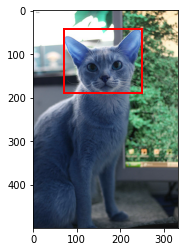

In [13]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(orignal_image)

# Create a Rectangle patch
rect = patches.Rectangle((x0_scaledback, y0_scaledback), x1_scaledback - x0_scaledback, y1_scaledback - y0_scaledback, linewidth=2, edgecolor='r', facecolor='none')
# shift+tab on patches.Rectangle u will see it takes 4 arguments x,y,w,h. It takes x,y in a tuple.

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

Now since we are using mobilenet here. Mobile net has its own preprocessing of input. We only have image names in the x_train untill now. We will take up the image name, pass it to the path and bring the orignal image from the database. Then we will resize it to 128x128 (mobile net can take other sizes if input as well one of which is 128x128). After resizing our image to 128x128 we will pass it to mobilenet's preprocess_input function and replace the link in x_train with the array that we will get from preprocess_input.<br> **This is an expensive process since we have 3006 images. It will take each link, bring the photo, resize it and pass it for mobilenet preprocessing.**

In [14]:
%%time
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, imagename in enumerate(X_train):
  img = Image.open(DATASET_FOLDER + imagename) # Read image
  img = img.resize((128, 128)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

CPU times: user 20.2 s, sys: 1.02 s, total: 21.2 s
Wall time: 14min 26s


**As u remember x_train was a list of 3006 image names. Now it is a list of 3006 image arrays(128x128x3) we got from mobilenet preprocessing**

In [15]:
print(len(X_train))

3006


**From a list of arrays we will convert x_train to array of arrays(image arrays)**

In [16]:
X_train = np.array(X_train)
X_train.shape

(3006, 128, 128, 3)

# Processing validation set (same what we did above with training set):

In [17]:
df_val = pd.read_csv(VALIDATION_CSV, header=None)
df_val.columns=["path","H","W","x0","y0","x1","y1","label_1","label_2"]
print(df_val.shape)
df_val

(680, 9)


,path,H,W,x0,y0,x1,y1,label_1,label_2
0,C:/Users/Amit/Documents/Great Learning/M6 Adva...,500,333,1,34,257,303,abyssinian,0
1,C:/Users/Amit/Documents/Great Learning/M6 Adva...,500,333,88,94,207,195,abyssinian,0
2,C:/Users/Amit/Documents/Great Learning/M6 Adva...,320,311,17,25,206,180,abyssinian,0
3,C:/Users/Amit/Documents/Great Learning/M6 Adva...,500,335,164,71,252,163,abyssinian,0
4,C:/Users/Amit/Documents/Great Learning/M6 Adva...,422,477,16,16,431,357,abyssinian,0
...,...,...,...,...,...,...,...,...,...
675,C:/Users/Amit/Documents/Great Learning/M6 Adva...,225,300,80,4,251,121,yorkshire_terrier,36
676,C:/Users/Amit/Documents/Great Learning/M6 Adva...,375,500,135,13,293,216,yorkshire_terrier,36
677,C:/Users/Amit/Documents/Great Learning/M6 Adva...,375,500,205,106,318,238,yorkshire_terrier,36
678,C:/Users/Amit/Documents/Great Learning/M6 Adva...,382,500,97,18,290,245,yorkshire_terrier,36


In [18]:
new_image_width=128
new_image_height=128

with open(VALIDATION_CSV, "r") as f:

  y_val = np.zeros((680, 4))
  X_val = []
  data = csv.reader(f, delimiter=',')
  for idx,row in enumerate(data):
    path, orignal_image_height, orignal_image_width, x0, y0, x1, y1, _, _ = row
    image_name = path.split("/")[-1]
    y_val[idx, 0] = int(x0) * new_image_width / int(orignal_image_width) #x0 scaled to new image width i.e 128
    y_val[idx, 1] = int(y0) * new_image_height / int(orignal_image_height) #y0 scaled to new image height i.e 128
    y_val[idx, 2] = (int(x1) - int(x0)) * new_image_width / int(orignal_image_width) #(x1-x0) is width of bounding box(again scaling to new image width 128)
    y_val[idx, 3] = (int(y1) - int(y0)) * new_image_height / int(orignal_image_height) #(y1-y0) is height of bounding box(again scaling to new image height 128)
    X_val.append(image_name)

In [19]:
print(len(X_val))
X_val[:5]

680


['Abyssinian_118.jpg',
 'Abyssinian_124.jpg',
 'Abyssinian_131.jpg',
 'Abyssinian_14.jpg',
 'Abyssinian_15.jpg']

In [20]:
y_val[9]

array([86.34920635, 68.69333333, 35.89417989, 48.21333333])

**Looking at 9th image from the test set**

In [21]:
filename = X_val[9] #9th image
orignal_image = cv2.imread(DATASET_FOLDER + X_val[9]) #9th image
print(orignal_image.shape)

x0,y0,w,h = y_val[9] #9th image
orignal_image_height, orignal_image_width, _ = orignal_image.shape

x0_scaledback = int(x0 * orignal_image_width / new_image_width) 
y0_scaledback = int(y0 * orignal_image_height / new_image_height)

x1_scaledback = int((w + x0) * orignal_image_width / new_image_width)
y1_scaledback = int((h + y0) * orignal_image_height / new_image_height)

(300, 378, 3)


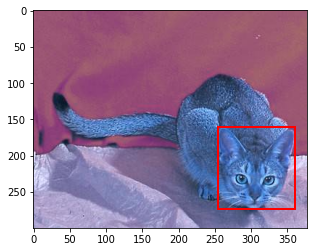

In [22]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(orignal_image)

# Create a Rectangle patch
rect = patches.Rectangle((x0_scaledback, y0_scaledback), x1_scaledback - x0_scaledback, y1_scaledback - y0_scaledback, linewidth=2, edgecolor='r', facecolor='none')
# shift+tab on patches.Rectangle u will see it takes 4 arguments x,y,w,h. It takes x,y in a tuple.

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [24]:
%%time
for i, imagename in enumerate(X_val):
  img = Image.open(DATASET_FOLDER + imagename) # Read image
  img = img.resize((128, 128)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

CPU times: user 4.51 s, sys: 173 ms, total: 4.69 s
Wall time: 3min 24s


In [25]:
X_val = np.array(X_val)
X_val.shape

(680, 128, 128, 3)

In [26]:
y_val
y_val.shape

(680, 4)

# Lets create model now in part 2 of this workbook
### but before that lets save the image arrays to use in next part

In [31]:
from numpy import save
save('/content/drive/My Drive/Colab Notebooks/x_train.npy', X_train)
save('/content/drive/My Drive/Colab Notebooks/x_val.npy', X_val)

save('/content/drive/My Drive/Colab Notebooks/y_train.npy', y_train)
save('/content/drive/My Drive/Colab Notebooks/y_val.npy', y_val)